# Neural Network

In [1]:
# Import Dependencies
import torch # PyToch library for building and training neural networks
from torch import nn
from torch.optim import Adam
import numpy as np # for numerical calculations
from collections import namedtuple, deque # provides useful data structures may not need
import random # for random sampling 
from mss import mss # for grabbing a screen shot of a monitor 
import pydirectinput # for mouse and keyboard input on windows
import cv2 as cv # for image and video processing
import pytesseract # OCR tool for reading text from images
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from gymnasium.utils import env_checker  # Import the environment checker
from collections import deque

def plot_learning_curve(x, scores, epsilons, filename, lines=None):
	fig=plt.figure()
	ax=fig.add_subplot(111, label="1")
	ax2=fig.add_subplot(111, label="2", frame_on=False)

	ax.plot(x, epsilons, color="C0")
	ax.set_xlabel("Training Steps", color="C0")
	ax.set_ylabel("Epsilon", color="C0")
	ax.tick_params(axis='x', colors="C0")
	ax.tick_params(axis='y', colors="C0")

	N = len(scores)
	running_avg = np.empty(N)
	for t in range(N):
		running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

	ax2.scatter(x, running_avg, color="C1")
	ax2.axes.get_xaxis().set_visible(False)
	ax2.yaxis.tick_right()
	ax2.set_ylabel('Score', color="C1")
	ax2.yaxis.set_label_position('right')
	ax2.tick_params(axis='y', colors="C1")

	if lines is not None:
		for line in lines:
			plt.axvline(x=line)

	plt.savefig(filename)


# Designing DQN Model
class DQN(nn.Module): # defines a new neural network model that inherits from Pytorch's base class nn.module
	def __init__(self, lr, input_dims, fc1_dims, fc2_dims, num_actions): 
		super(DQN, self).__init__() # calls the initializer of the parent class nn.module 
		self.input_dims = input_dims
		self.fc1_dims = fc1_dims
		self.fc2_dims = fc2_dims
		self.conv1 = nn.Conv2d(self.input_dims[0], 32, kernel_size=8, stride=4) # convolutional layer with 32 filters, each of size 8 x8, applied with a stride of 4
		self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # convolutional layer with 64 filters, each of size 4 x 4, applied with a stride of 2
		self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # convolutional layer with 64 filters, each of size 3 x 3
		self.fc_input_size = self._calculate_fc_input_size(self.input_dims)
		self.fc1 = nn.Linear(self.fc_input_size, self.fc1_dims) # fully connected layer with 512 units
		self.fc2 = nn.Linear(self.fc2_dims, num_actions) # final fully connected layer with output units equal to the number of possible actions
		self.optimizer = Adam(self.parameters(), lr=lr)
		self.loss = nn.MSELoss()
		self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
		self.to(self.device)
		
	def _calculate_fc_input_size(self, input_dims):
		with torch.no_grad():
			dummy_input = torch.zeros(1, input_dims[0], 50, 80)
			x = torch.relu(self.conv1(dummy_input))
			x = torch.relu(self.conv2(x))
			x = torch.relu(self.conv3(x))
			
			return x.view(1, -1).size(1)  # Flatten and get the size
		
	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = torch.relu(self.conv2(x))
		x = torch.relu(self.conv3(x))
		x = x.view(x.size(0), -1) # Flatten the output from conv layers
		x = torch.relu(self.fc1(x))
		actions =  self.fc2(x)  # Output Q-Values for each action
		
		return actions
	
# Creating Replay Buffer
class ReplayBuffer:
    def __init__(self, max_mem_size, input_dims):
        self.mem_size = max_mem_size 
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_cntr += 1
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch =random.sample(range(max_mem), batch_size)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]
        return states, actions, rewards, new_states, dones
  
# Creating DQN Agent
class DQNAgent:       
	def __init__(self, gamma, epsilon, lr, input_dims, batch_size, num_actions,
				 max_mem_size=10000, eps_end=0.01, eps_dec=0.99, replace_target=1000):
		self.gamma = gamma # Determines the weighting of future rewards
		self.epsilon = epsilon
		self.epsilon_end = eps_end
		self.epsilon_decay = eps_dec
		self.lr = lr
		self.action_space = [i for i in range(num_actions)]
		self.num_actions = num_actions
		self.batch_size = batch_size
		self.replace_target = replace_target # Number of steps before updating target network
		self.learn_step_counter = 0 # Track the steps for target network update
		
		# Initialize evaluation (q_eval) and target (q_target) network
		self.q_eval = DQN(self.lr, input_dims, fc1_dims=512, fc2_dims=512, num_actions=num_actions)
		self.q_target = DQN(self.lr, input_dims, fc1_dims=512, fc2_dims=512, num_actions=num_actions)
  
		# Initially, the target network has the same weights as the evaluation network
		self.q_target.load_state_dict(self.q_eval.state_dict())
		self.q_target.eval()
  
		# Initialize the replay buffer
		self.memory = ReplayBuffer(max_mem_size, input_dims)
		self.optimizer = Adam(self.q_eval.parameters(), lr=self.lr)
		self.loss = nn.MSELoss()
		self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
	def store_transition(self, state, action, reward, state_, done):
		self.memory.store_transition(state, action, reward, state_, done)
  
	# Method for choosing an action
	def choose_action(self, observation):
		if np.random.random() > self.epsilon:
			observation = observation / 255.0
			state = torch.tensor([observation], dtype=torch.float32).to(self.q_eval.device)
			actions = self.q_eval.forward(state)
			action = torch.argmax(actions).item()
		else:
			action = np.random.choice(self.action_space)
		return action

	def replace_target_network(self):
		if self.learn_step_counter % self.replace_target == 0:
			self.q_target.load_state_dict(self.q_eval.state_dict())
			print('Target network updated.')
	
	def learn(self):
		if self.memory.mem_cntr < self.batch_size:
			return
		self.optimizer.zero_grad()
		
		self.replace_target_network()
  
		states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
		
		states = torch.tensor(states).to(self.q_eval.device)
		rewards = torch.tensor(rewards).to(self.q_eval.device)
		dones = torch.tensor(dones, dtype=torch.float32).to(self.q_eval.device)
		actions = torch.tensor(actions).to(self.q_eval.device)
		states_ = torch.tensor(states_).to(self.q_eval.device)
		
		# Q-values for the next state from the target network (for stability)
		q_next = self.q_target.forward(states_).max(dim=1)[0]

		# Q-values for current state from evaluation network
		q_pred = self.q_eval.forward(states)[range(self.batch_size), actions]
		
		# Calculate target Q-values using Bellman equation
		q_target = rewards + self.gamma *  q_next * (1 - dones)
		
		# Compute loss between predicted Q-values and target Q-values
		loss = self.loss(q_pred, q_target)
		loss.backward()
		self.optimizer.step()

		# Increment the step counter		
		self.learn_step_counter += 1
  
		return loss.item()

# Custom Environment Class

In [2]:
# Import Dependencies
import torch # PyToch library for building and training neural networks
from torch import nn
from torch.optim import AdamW
import numpy as np # for numerical calculations
from collections import namedtuple, deque # provides useful data structures may not need
import random # for random sampling 
from mss import mss # for grabbing a screen shot of a monitor 
import pydirectinput # for mouse and keyboard input on windows
import cv2 as cv # for image and video processing
import pytesseract # OCR tool for reading text from images
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from gymnasium.utils.env_checker import check_env  # Import the environment checker
from collections import deque
import math


class PacMan(Env):
    def __init__(self):
        super().__init__()
        
        # Define spaces
        self.observation_space = Box(low=0, high=255, shape=(6,50,80), dtype=np.uint8)
        self.action_space = Discrete(4) # number of possible actions
        
        # Define capture locations
        self.cap = mss()
        self.game_location = {'top':50, 'left':-2280, 'width':1400, 'height':1300}# defines game viewing location
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200} # defines lives location
        self.frame_stack = deque(maxlen=6) # stack frames to provide a sense of motion
        #self.score_location = {'top':380, 'left':-920, 'width':600, 'height':80} # defines score location
        #self.done_location = {'top':508, 'left':-1810, 'width':450, 'height':80} 
            
        # Define lives
        self.previous_lives = 2
        self.current_lives = self.previous_lives
        self.previous_score = 0
        self.time_alive = 0
        self.last_life = 2
        self.survival_reward_factor = 0.01
        
        # Define pellet count
        self.pellet_address = 0x7268 # ROM memory address
        self.file_path = "pellet_count.txt" # file to store value
        self.previous_pellet_count = self.read_pellet_count_from_file()
        

        # Define templates for tracking
        self.ghost_template = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\ghost_template.png', 0)
        self.ghost_template2 = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\ghost_template3.png', 0)
        self.ghost_template3 = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\ghost_template4.png', 0)
        self.pacman_life_template = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_life_icon.png', 0)
        self.pacman_template_left = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_template_left.png', 0)
        self.pacman_template_right = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_template_right.png', 0)
        self.pacman_template_up = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_template_up.png', 0)
        self.pacman_template_down = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_template_down.png', 0)
        self.pacman_template_closed = cv.imread('C:\\Users\\John Wesley\\Docs\\PacMan\\PacManGame\\Images\\pacman_template_closed.png', 0)
        
    # Observation of the state of the environment
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Grayscale
        gray = cv.cvtColor(raw, cv.COLOR_BGR2GRAY)
        # Resize
        resized = cv.resize(gray, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel
    
    def get_stacked_observation(self):
        # Stack the frames in the deque and convert to the required shape
        return np.concatenate(list(self.frame_stack), axis=0)
    
    # Get number of lives left
    def get_lives(self):   
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv.cvtColor(lives_cap, cv.COLOR_BGR2GRAY)
        # Perform template matching
        result = cv.matchTemplate(lives_gray, self.pacman_life_template, cv.TM_CCORR_NORMED)
        locations = np.where(result >= 0.8) # find areas that have values at or above threshold value
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2 
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives
    
    # Get game over
    def get_done(self):
        # Get the number of lives left 
        num_lives = self.get_lives()
        return num_lives == 0 # return bool
    
    # Get pellet count
    def read_pellet_count_from_file(self):
        try:
            with open(self.file_path, "r") as file:
                return int(file.read().strip())
        except (FileNotFoundError, ValueError):
            return 0
        
    # Resets the environment to its initial state
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # restart the game
        pydirectinput.click(x=-890, y=374) # Select game window
        pydirectinput.press('f1') # Start state 1 save
        # Reset pellet count
        self.previous_pellet_count = self.read_pellet_count_from_file()
        # Reset frame stack
        self.frame_stack.clear() # Delete all items from Deque
        # Update deque with reset state
        for _ in range(6):
            initial_frame = self.get_observation()
            self.frame_stack.append(initial_frame)
            
        return self.get_stacked_observation(), {}
    
    # Rendering method to see what the computer sees
    def render(self):
        frame = self.render_positions()
        cv.imshow('Game', frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            self.close()
            
    # Closes rendering window        
    def close(self):
        cv.destroyAllWindows()
    
    # Find character locations on screen            
    def get_character_positions(self):
        screen_capture = np.array(self.cap.grab(self.game_location))[:,:,:3]
        cv.imwrite('game_capture.png', screen_capture)
        # Convert to grayscale
        gray_screen = cv.cvtColor(screen_capture, cv.COLOR_BGR2GRAY)
        
        # Match the templates to find Pac-Man and Ghosts
        result_left = cv.matchTemplate(gray_screen, self.pacman_template_left, cv.TM_CCOEFF_NORMED)
        result_right = cv.matchTemplate(gray_screen, self.pacman_template_right, cv.TM_CCOEFF_NORMED)
        result_up = cv.matchTemplate(gray_screen, self.pacman_template_up, cv.TM_CCOEFF_NORMED)
        result_down = cv.matchTemplate(gray_screen, self.pacman_template_down, cv.TM_CCOEFF_NORMED)
        result_closed = cv.matchTemplate(gray_screen, self.pacman_template_closed, cv.TM_CCOEFF_NORMED)
        result_ghost = cv.matchTemplate(gray_screen, self.ghost_template, cv.TM_CCOEFF_NORMED)
        result_ghost2 = cv.matchTemplate(gray_screen, self.ghost_template2, cv.TM_CCOEFF_NORMED)
        result_ghost3 = cv.matchTemplate(gray_screen, self.ghost_template3, cv.TM_CCOEFF_NORMED)
        
        # Locate pacman
        pacman_threshold = 0.6 # Adjust this value based on testing
        locations_left = np.where(result_left >= pacman_threshold)
        locations_right = np.where(result_right >= pacman_threshold)
        locations_up = np.where(result_up >= pacman_threshold)
        locations_down = np.where(result_down >= pacman_threshold)
        locations_closed = np.where(result_closed >= pacman_threshold)
        
        # Locate ghosts
        ghost_threshold = 0.5
        location_ghost = np.where(result_ghost >= ghost_threshold)
        location_ghost2 = np.where(result_ghost2 >= ghost_threshold)
        location_ghost3 = np.where(result_ghost3 >= ghost_threshold)
        
        # Pack locations
        pacman_combined_locations = list(zip(*locations_left[::-1])) + list(zip(*locations_right[::-1])) + list(zip(*locations_up[::-1])) + list(zip(*locations_down[::-1])) + list(zip(*locations_closed[::-1]))
        ghost_position = list(zip(*location_ghost[::-1])) + list(zip(*location_ghost2[::-1]))  + list(zip(*location_ghost3[::-1]))

        return ghost_position, pacman_combined_locations, screen_capture
    
    # Method to see character detection    
    def render_positions(self):
        # Get character positions
        ghost_position, pacman_combined_locations, screen_capture = self.get_character_positions()

        screen_capture = np.ascontiguousarray(screen_capture) # convert captured image to OpenCV compatability
        
        # Draw rectangles around matched Pac-Man locations using OpenCV
        for loc in pacman_combined_locations:
            top_left = loc
            bottom_right = (top_left[0] + self.pacman_template_right.shape[1], top_left[1] + self.pacman_template_right.shape[0])
            # Create a rectangle patch and add it to the plot
            cv.rectangle(screen_capture, top_left, bottom_right, (255, 0, 0), 2)
            
        # Draw rectangles around matched Ghost locations using OpenCV
        for loc in ghost_position:
            top_left = loc
            bottom_right = (top_left[0] + self.ghost_template.shape[1], top_left[1] + self.ghost_template.shape[0])
            # Create a rectangle patch and add it to the plot
            cv.rectangle(screen_capture, top_left, bottom_right, (0, 0, 255), 2)

        # cv.imshow('Test Render positions', screen_capture)
        # cv.waitKey(0)
        # cv.destroyAllWindows()
        return screen_capture
    
    def calculate_distance (self, pacman_pos, ghost_pos):
        # Unpack positions
        pacman_x, pacman_y = pacman_pos
        ghost_x, ghost_y = ghost_pos
        return math.sqrt((ghost_x - pacman_x) ** 2 + (ghost_y - pacman_y) ** 2)
    
    # Calculate reward for eating pellets
    def get_pellet_reward(self, current_pellet_count):
        if current_pellet_count < self.previous_pellet_count:
            reward = 20
            self.previous_pellet_count = current_pellet_count
        else:
            reward = 0    
        return reward
    
    def ghost_avoidance_reward(self):
        ghost_positions, pacman_combined_locations, _ = self.get_character_positions()
        if pacman_combined_locations:
            pacman_pos = pacman_combined_locations[0]
        else:
            pacman_pos = (0, 0)
        safe_distance = 260
        avoidance_reward = 0
        num_considered_ghosts = min(len(ghost_positions), 4)
        
        for ghost_pos in ghost_positions[:num_considered_ghosts]:
            distance = self.calculate_distance(pacman_pos, ghost_pos)
            #print(f"Ghost {ghost_index + 1} Position: {ghost_pos}, Distance: {distance}")
            if distance > safe_distance:
                # avoidance_reward += (distance - safe_distance)
                avoidance_reward += 20 / num_considered_ghosts
            else:
                # avoidance_reward -= (safe_distance - distance) * 2
                avoidance_reward -= 10
        return avoidance_reward
    
    # Method that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
        }
        
        pydirectinput.press(action_map[action])
        
        # Reward for eating pellets 
        # current_pellet_count = self.read_pellet_count_from_file()
        # pellet_reward = self.get_pellet_reward(current_pellet_count)
        # Reward for avoiding ghosts
        avoidance_reward = self.ghost_avoidance_reward()
        # Bonus reward for staying alive      
        current_lives = self.get_lives()
        # if current_lives < self.last_life:
        #     self.time_alive = 0
        #     self.last_life = current_lives
        # self.time_alive += 1
        # # survival_reward = self.survival_reward_factor * (1.1 ** self.time_alive)
        # survival_reward = self.time_alive * 1.01 
        # Penalize only when a life is lost (and only once per life loss)
        life_penalty = 0
        if current_lives < self.previous_lives:
            life_penalty -= 40
            self.previous_lives = current_lives # update previous lives 
           
        reward = avoidance_reward + life_penalty 
        
        done = self.get_done()
        
        # Get the next observation
        new_frame = self.get_observation()
        self.frame_stack.append(new_frame)
        stacked_observation = self.get_stacked_observation()
        
        return stacked_observation, reward, done, False, {}

In [3]:
# env = PacMan()

# check_env(env, warn=True)

# Main

------------------------
| episodes   |   0    |
| score      |  213.73 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   1    |
| score      |  433.52000000000004 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   2    |
| score      |  415.53 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   3    |
| score      |  578.14 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   4    |
| score      |  1164.9099999999999 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   5    |
| score      |  1304.64 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   6    |
| score      |  1232.4100000000003 |
| epsilon    |  1.00   |
------------------------

------------------------
| episodes   |   7    |
| score      |  1510.3700000000001 |
| 

C:\Users\John Wesley\AppData\Local\Temp\ipykernel_21556\2200964324.py:150: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([observation], dtype=torch.float32).to(self.q_eval.device)


------------------------
| episodes   |   37    |
| score      |  8655.12 |
| epsilon    |  0.97   |
------------------------
, loss 30751.9707
------------------------
| episodes   |   38    |
| score      |  6081.63 |
| epsilon    |  0.97   |
------------------------
, loss 26103.9297
------------------------
| episodes   |   39    |
| score      |  9591.990000000002 |
| epsilon    |  0.97   |
------------------------
, loss 27264.4688
------------------------
| episodes   |   40    |
| score      |  9903.88 |
| epsilon    |  0.96   |
------------------------
, loss 37264.1406
Model saved as saved_models/best_pacman_dqn_model_40.pth
------------------------
| episodes   |   41    |
| score      |  10871.67 |
| epsilon    |  0.96   |
------------------------
, loss 38200.8477
------------------------
| episodes   |   42    |
| score      |  11753.999999999998 |
| epsilon    |  0.96   |
------------------------
, loss 34859.8672
------------------------
| episodes   |   43    |
| score

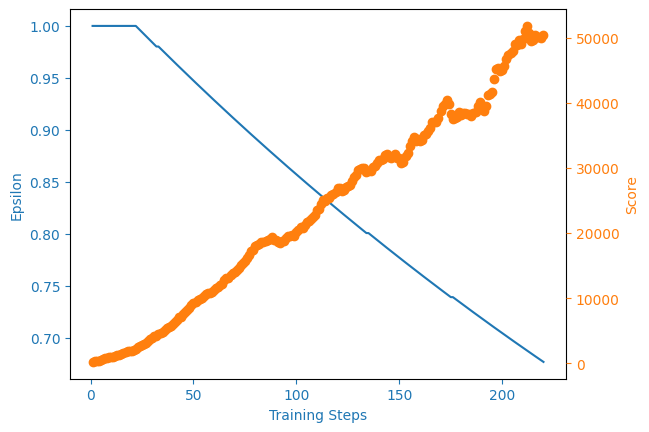

In [4]:

if __name__ == '__main__':
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    env = PacMan()
    
    agent = DQNAgent(gamma=0.99, epsilon=1.0, batch_size=64, num_actions=4, 
                     eps_end=0.01, eps_dec=0.998, input_dims=(6, 50, 80), lr=0.001)
    agent.q_eval.to(device)
    agent.q_target.to(device)
    
    scores, eps_history = [], []
    n_games = 220
    best_score = -np.inf # initialize best score to a low value
    save_folder = 'saved_models'
    learn_interval = 10 # Call learn() every 10 steps
    warmup_eps = 20 # Episodes before the agent starts learning
    step_counter = 0 
    
    for i in range(n_games):
        score = 0
        done = False
        observation, _ = env.reset()
        loss = None
        previous_loss = float('inf')
        has_learned = False
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, truncated, info = env.step(action)
            score += reward
            
            agent.store_transition(observation, action, reward, observation_, done)
            
            step_counter += 1
            # Start learning only after warm-up period and learn periodically
            if i > warmup_eps and step_counter % learn_interval == 0:
                loss = agent.learn() # this is batch learning
                has_learned = True
            observation = observation_
            # env.render()
            
        scores.append(score)
        eps_history.append(agent.epsilon)
        
        # Calcualte average score over the last 100 games
        avg_score = np.mean(scores[-100:])
        
        print('------------------------')
        print(f'| episodes   |   {i}    |')
        print(f'| score      |  {score} |')
        print(f'| epsilon    |  {agent.epsilon:.2f}   |')
        print('------------------------')
        if loss is not None:
            print(f', loss {loss:.4f}')
        else: 
            print() # Just print a new line if loss is None
            
        if has_learned and loss < previous_loss:
            agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
            # print(f"Updated epsilon: {agent.epsilon}") # debug statement
        previous_loss = loss if loss is not None else previous_loss
        # Save the model if the average score improves
        # Save the model every 10 episodes
        if has_learned and i % 10 == 0:
            model_filename = f'{save_folder}/best_pacman_dqn_model_{i}.pth'
            torch.save(agent.q_eval.state_dict(), model_filename)
            print(f'Model saved as {model_filename}')

    x = [i+1 for i in range(n_games)]
    filename = 'pacman_plot.png'
    plot_learning_curve(x, scores, eps_history, filename)
    

In [5]:
# # To load the model later
# model_filename = 'pacman_dqn_model.pth'
# agent.q_eval.load_state_dict(torch.load(model_filename))
# agent.q_eval.eval()  # Set the model to evaluation mode


In [6]:
print('------------------------')
print(f'| episodes   |   {i}    |')
print(f'| score      |  {score} |')
print(f'| epsilon    |  {agent.epsilon:.2f}   |')
print('------------------------')

------------------------
| episodes   |   219    |
| score      |  47412.24999999999 |
| epsilon    |  0.68   |
------------------------
